In [16]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [17]:
def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

In [18]:
config = load_config()
od = '../../snakemake/compare_external/'

## Compare just refseq and gencode

In [4]:
df = pd.DataFrame()
ics = [od+config['ref']['cerb']['ics'],
       od+config['ref']['refseq']['cerb']['ics']]
sources = ['GENCODE v47', 'RefSeq v110']
for ic, source in zip(ics, sources):
    temp = pd.read_csv(ic, sep='\t')
    
    # remove monoexonic, add source, drop name
    temp = temp.loc[temp.Coordinates != '-']
    temp['source'] = source
    temp = temp.drop('Name', axis=1)
    
    df = pd.concat([df, temp], axis=0)    

In [5]:
temp = df.copy(deep=True)
df = df.pivot_table(
    index=['Strand', 'Coordinates', 'Chromosome'],
    columns='source',
    aggfunc=lambda x: True,
    fill_value=False).reset_index()
# df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df.columns.values]
df.head()
df.reset_index(drop=True, inplace=True)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


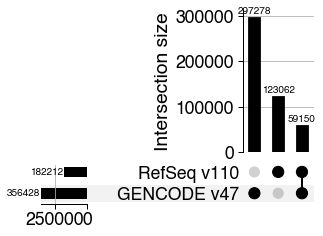

In [6]:
temp = df[sources+['Strand']].groupby(sources).count().reset_index()
temp.rename({'Strand':'n_ic'}, axis=1, inplace=True)
temp.head()
df = df.merge(temp[sources+['n_ic']], 
              how='left',
              on=sources)
df.set_index(sources, inplace=True)
init_plot_settings(font_scale=1)
upsetplot.plot(df, sort_by='cardinality', show_counts=True)
plt.savefig('annot_overlap_upset_references.pdf', dpi=500)

## Make table of PODER transcripts (incl. tid) with their status in external things

In [51]:
# get ic <-> tid
df = pd.DataFrame()
gtfs = [od+config['lr']['gtf_filt_with_genes']]
sources = ['PODER']

for f, s in zip(gtfs, sources):
    temp = pr.read_gtf(f)
    temp = cerberus.get_ic(temp)
    temp['source'] = s
    df = pd.concat([df, temp], axis=0)
    
ics_df = df.copy(deep=True)    
ics_df['ic_id'] = ics_df.Chromosome.astype(str)+'_'+\
                  ics_df.Strand.astype(str)+'_'+\
                  ics_df.ic.astype(str)

In [52]:
df = pd.DataFrame()
ics = [od+config['gtex']['cerb']['ics'],
       od+config['chess']['cerb']['ics'],
       od+config['enc']['cerb']['ics'],
       od+config['lr']['cerb']['ics'],
       od+config['ref']['cerb']['ics'],
       od+config['ref']['refseq']['cerb']['ics']]
sources = ['GTEx', 'CHESS3', 'ENCODE4', 'PODER', 'GENCODE v47', 'RefSeq v110']
for ic, source in zip(ics, sources):
    temp = pd.read_csv(ic, sep='\t')
    
    # remove monoexonic, add source, drop name
    temp = temp.loc[temp.Coordinates != '-']
    temp['source'] = source
    temp = temp.drop('Name', axis=1)
    
    df = pd.concat([df, temp], axis=0)    
temp = df.copy(deep=True)
df = df.pivot_table(
    index=['Strand', 'Coordinates', 'Chromosome'],
    columns='source',
    aggfunc=lambda x: True,
    fill_value=False).reset_index()
# df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df.columns.values]
df.head()
df.reset_index(drop=True, inplace=True)

In [53]:
# limit to poder = true 
df = df.loc[df.PODER==True]

# add ic id w/ chrom and strand
df['ic_id'] = df.Chromosome.astype(str)+'_'+\
              df.Strand.astype(str)+'_'+\
              df.Coordinates.astype(str)

In [54]:
ics_df.head(1)

,Chromosome,Strand,transcript_id,gene_id,ic,source,ic_id
0,GL000008.2,-,transcript_190114,ENSG00000296775.1,170271-163998-163784-162439,PODER,GL000008.2_-_170271-163998-163784-162439


In [55]:
df = df.merge(ics_df[['transcript_id', 'ic_id']],
              how='left', 
              on='ic_id')
df.head()

,Strand,Coordinates,Chromosome,CHESS3,ENCODE4,GENCODE v47,GTEx,PODER,RefSeq v110,ic_id,transcript_id
0,+,1000064-1000611-1000697-1000881-1000989-100146...,chr4,True,False,True,False,True,True,chr4_+_1000064-1000611-1000697-1000881-1000989...,ENST00000652070.1
1,+,100015726-100023418-100023932-100024153,chr7,False,True,True,False,True,False,chr7_+_100015726-100023418-100023932-100024153,transcript_162764
2,+,100015726-100023418-100023932-100024153-100024...,chr7,True,True,True,True,True,True,chr7_+_100015726-100023418-100023932-100024153...,transcript_162766
3,+,100015726-100029860-100029952-100030248-100030...,chr7,True,True,True,False,True,True,chr7_+_100015726-100029860-100029952-100030248...,transcript_162769
4,+,100038316-100043072-100043229-100049908-100050...,chr1,True,False,False,True,True,False,chr1_+_100038316-100043072-100043229-100049908...,transcript_338


In [56]:
assert len(df.loc[df.transcript_id.isnull()]) ==0

In [57]:
df.to_csv('241121_poder_transcripts_by_external_support.tsv', sep='\t')

## Compare all annotations

In [58]:
df = pd.DataFrame()
ics = [od+config['gtex']['cerb']['ics'],
       od+config['chess']['cerb']['ics'],
       od+config['enc']['cerb']['ics'],
       od+config['lr']['cerb']['ics'],
       od+config['ref']['cerb']['ics'],
       od+config['ref']['refseq']['cerb']['ics']]
sources = ['GTEx', 'CHESS3', 'ENCODE4', 'PODER', 'GENCODE v47', 'RefSeq v110']
for ic, source in zip(ics, sources):
    temp = pd.read_csv(ic, sep='\t')
    
    # remove monoexonic, add source, drop name
    temp = temp.loc[temp.Coordinates != '-']
    temp['source'] = source
    temp = temp.drop('Name', axis=1)
    
    df = pd.concat([df, temp], axis=0)    

In [59]:
temp = df.copy(deep=True)
df = df.pivot_table(
    index=['Strand', 'Coordinates', 'Chromosome'],
    columns='source',
    aggfunc=lambda x: True,
    fill_value=False).reset_index()
# df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df.columns.values]
df.head()
df.reset_index(drop=True, inplace=True)

In [60]:
# df.loc[(df.chess==True)&(df.gtex==True)].Coordinates.tolist()[0]
# temp.loc[temp.Coordinates=='100015726-100019230-100019349-100023418-100023932-100024153-100024307-100029860-100029952-100030248-100030375-100033304']
# df.head()
# df['id'] = df.Strand+'_'+df.Chromosome+'_'+df.Coordinates
# df.drop(['Strand', 'Chromosome', 'Coordinates'], axis=1, inplace=True)
# df = df.groupby(['chess', 'gtex']).count().rename({'id':'n_ics'}, axis=1)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


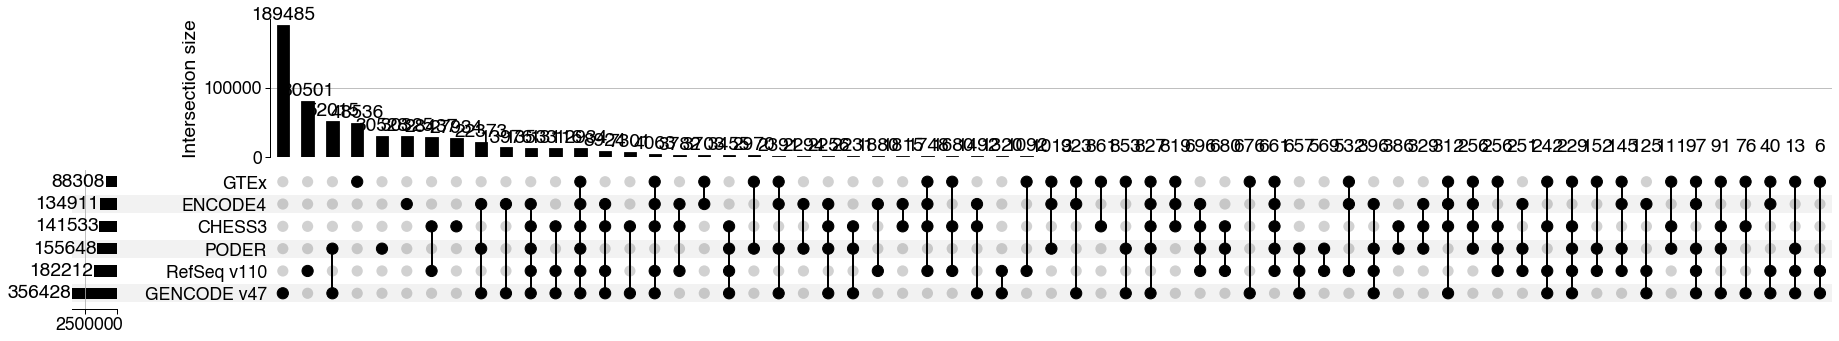

In [61]:
temp = df[sources+['Strand']].groupby(sources).count().reset_index()
temp.rename({'Strand':'n_ic'}, axis=1, inplace=True)
temp.head()
df = df.merge(temp[sources+['n_ic']], 
              how='left',
              on=sources)
df.set_index(sources, inplace=True)
init_plot_settings(font_scale=1)
upsetplot.plot(df, sort_by='cardinality', show_counts=True)
plt.savefig('annot_overlap_upset.pdf', dpi=500)

In [62]:
temp.head()

source,GTEx,CHESS3,ENCODE4,PODER,GENCODE v47,RefSeq v110,n_ic
0,False,False,False,False,False,True,80501
1,False,False,False,False,True,False,189485
2,False,False,False,False,True,True,1320
3,False,False,False,True,False,False,30528
4,False,False,False,True,False,True,569


In [63]:
# remove entries that are past a certain number
temp = df.loc[df.n_ic >= 21000].copy(deep=True)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


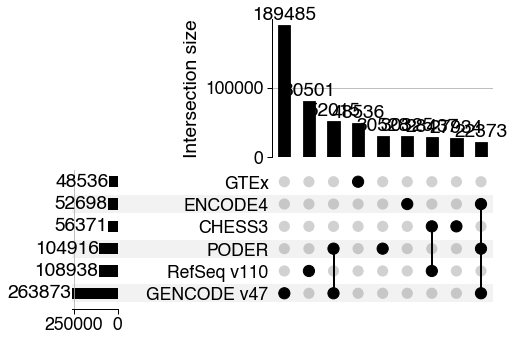

In [64]:
init_plot_settings(font_scale=1)
upsetplot.plot(temp, sort_by='cardinality', show_counts=True)
plt.savefig('annot_overlap_upset_short.pdf', dpi=500)

## % of FSM transcripts supported by other annotations

In [65]:
df  = df.reset_index()
df.head()

source,GTEx,CHESS3,ENCODE4,PODER,GENCODE v47,RefSeq v110,Strand,Coordinates,Chromosome,n_ic
0,False,False,False,False,False,True,+,10000-10669-10744-13745-14013-18875-18940-19252,KZ208910.1,80501
1,False,False,False,False,False,True,+,10000-10669-10744-18875-18940-19252,KZ208910.1,80501
2,False,False,False,False,False,True,+,10000-10669-10744-19252,KZ208910.1,80501
3,False,False,False,False,False,True,+,10000-10669-10749-18875-18940-19252,KZ208910.1,80501
4,False,False,False,False,False,True,+,10000-10669-10749-19252,KZ208910.1,80501


In [66]:
novel_sources = [s for s in sources if s not in ['GENCODE v47', 'RefSeq v110']]
perc_df = pd.DataFrame()
for s in novel_sources:
    
    # get annot transcripts from this annotation
    temp = df.loc[(df[s] == True)&(df['GENCODE v47']==True)].copy(deep=True)
    
    other_nov_sources = [ns for ns in novel_sources if ns != s]
    temp['supported_by_external'] = (df[other_nov_sources].sum(axis=1))>0
    temp = temp[['supported_by_external', 'Coordinates']]

    temp = temp.groupby('supported_by_external').count().reset_index().rename({'Coordinates':'n_ic'}, axis=1)
    temp['dataset'] = s
    temp['total'] = temp['n_ic'].sum(axis=0)
    temp['perc'] = (temp['n_ic']/temp['total'])*100
    
    temp = temp.loc[temp.supported_by_external==True]
    temp = temp[['dataset', 'perc', 'n_ic']]
    perc_df = pd.concat([perc_df, temp], axis=0)

In [67]:
perc_df

source,dataset,perc,n_ic
1,GTEx,97.131199,23091
1,CHESS3,71.276835,50665
1,ENCODE4,83.344358,70561
1,PODER,53.938313,61679


## What about the % of novel transcripts per de novo annotation that are supported by the other annotations?

In [32]:
df  = df.reset_index()
df.head()

source,GTEx,CHESS3,ENCODE4,PODER,GENCODE v47,Strand,Coordinates,Chromosome
0,False,False,False,False,True,+,100000063-100008120-100008322-100011375,chr7
1,False,False,False,False,True,+,100006296-100007901-100008231-100037527,chr4
2,False,True,False,True,True,+,1000064-1000611-1000697-1000881-1000989-100146...,chr4
3,False,False,False,False,True,+,100008231-100024938-100025080-100025281-100025...,chr4
4,False,True,True,False,True,+,100015726-100019230-100019349-100023418-100023...,chr7


In [33]:
novel_sources = [s for s in sources if s not in ['GENCODE v47', 'RefSeq v110']]
perc_df = pd.DataFrame()
for s in novel_sources:
    
    # get novel transcripts from this annotation
    temp = df.loc[(df[s] == True)&(df['GENCODE v47']==False)].copy(deep=True)
    
    other_nov_sources = [ns for ns in novel_sources if ns != s]
    temp['supported_by_external'] = (df[other_nov_sources].sum(axis=1))>0
    temp = temp[['supported_by_external', 'Coordinates']]

    temp = temp.groupby('supported_by_external').count().reset_index().rename({'Coordinates':'n_ic'}, axis=1)
    temp['dataset'] = s
    temp['total'] = temp['n_ic'].sum(axis=0)
    temp['perc'] = (temp['n_ic']/temp['total'])*100
    
    temp = temp.loc[temp.supported_by_external==True]
    temp = temp[['dataset', 'perc', 'n_ic']]
    perc_df = pd.concat([perc_df, temp], axis=0)

In [34]:
perc_df

source,dataset,perc,n_ic
1,GTEx,23.099094,14907
1,CHESS3,19.985522,14080
1,ENCODE4,35.909172,18044
1,PODER,24.699131,10200


In [35]:
temp2 = df.loc[df.ENCODE4==True]
temp2[['ENCODE4', 'GENCODE v47', 'Coordinates']].groupby(['ENCODE4', 'GENCODE v47']).count().reset_index()

source,ENCODE4,GENCODE v47,Coordinates
0,True,False,50249
1,True,True,84662


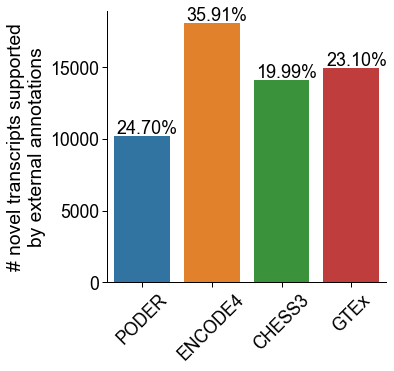

In [38]:
def add_perc_2(ax, df):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        h = p.get_height()
        tot = df.loc[df.n_ic==h, 'perc'].values[0]
        x = p.get_x() + p.get_width() / 2 - (0.09)*n_cats
        y = p.get_y() + p.get_height() + ylim*0.01
        ax.annotate(f'{tot:.2f}%', (x, y), size = 18)

init_plot_settings(aspect='square')
ax = sns.barplot(perc_df, y='n_ic', 
                 x='dataset', order=['PODER', 'ENCODE4', 'CHESS3', 'GTEx'])
add_perc_2(ax, perc_df)
ax.set(ylabel='# novel transcripts supported\nby external annotations',xlabel='')
clean_figure(ax)

In [40]:
perc_df.to_csv('241031_perc_supported_ics_per_annot.tsv', sep='\t')

In [15]:
perc_df = pd.read_csv('241031_perc_supported_ics_per_annot.tsv', sep='\t')
perc_df

,Unnamed: 0,dataset,perc,n_ic
0,1,GTEx,23.099094,14907
1,1,CHESS3,19.985522,14080
2,1,ENCODE4,35.909172,18044
3,1,PODER,24.699131,10200


## oppostite, # of novel transcripts unsupported

In [68]:
df  = df.reset_index()
df.head()

source,index,GTEx,CHESS3,ENCODE4,PODER,GENCODE v47,RefSeq v110,Strand,Coordinates,Chromosome,n_ic
0,0,False,False,False,False,False,True,+,10000-10669-10744-13745-14013-18875-18940-19252,KZ208910.1,80501
1,1,False,False,False,False,False,True,+,10000-10669-10744-18875-18940-19252,KZ208910.1,80501
2,2,False,False,False,False,False,True,+,10000-10669-10744-19252,KZ208910.1,80501
3,3,False,False,False,False,False,True,+,10000-10669-10749-18875-18940-19252,KZ208910.1,80501
4,4,False,False,False,False,False,True,+,10000-10669-10749-19252,KZ208910.1,80501


In [71]:
novel_sources = [s for s in sources if s not in ['GENCODE v47', 'RefSeq v110']]
perc_df = pd.DataFrame()
for s in novel_sources:
    
    # get novel transcripts from this annotation
    temp = df.loc[(df[s] == True)&(df['GENCODE v47']==False)].copy(deep=True)
    
    other_nov_sources = [ns for ns in novel_sources if ns != s]
    temp['supported_by_external'] = (df[other_nov_sources].sum(axis=1))>0
    temp = temp[['supported_by_external', 'Coordinates']]

    temp = temp.groupby('supported_by_external').count().reset_index().rename({'Coordinates':'n_ic'}, axis=1)
    temp['dataset'] = s
    temp['total'] = temp['n_ic'].sum(axis=0)
    temp['perc'] = (temp['n_ic']/temp['total'])*100
    
    temp = temp.loc[temp.supported_by_external==False]
    temp = temp[['dataset', 'perc', 'n_ic']]
    perc_df = pd.concat([perc_df, temp], axis=0)

In [72]:
perc_df

source,dataset,perc,n_ic
0,GTEx,76.900906,49628
0,CHESS3,80.014478,56371
0,ENCODE4,64.090828,32205
0,PODER,75.300869,31097


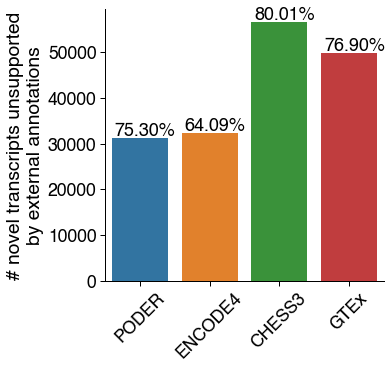

In [76]:
def add_perc_2(ax, df):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        h = p.get_height()
        tot = df.loc[df.n_ic==h, 'perc'].values[0]
        x = p.get_x() + p.get_width() / 2 - (0.09)*n_cats
        y = p.get_y() + p.get_height() + ylim*0.01
        ax.annotate(f'{tot:.2f}%', (x, y), size = 18)

init_plot_settings(aspect='square')
ax = sns.barplot(perc_df, y='n_ic', 
                 x='dataset', order=['PODER', 'ENCODE4', 'CHESS3', 'GTEx'])
add_perc_2(ax, perc_df)
ax.set(ylabel='# novel transcripts unsupported\nby external annotations',xlabel='')
clean_figure(ax)

In [74]:
perc_df.to_csv('241122_perc_unsupported_ics_per_annot.tsv', sep='\t')

In [75]:
perc_df

source,dataset,perc,n_ic
0,GTEx,76.900906,49628
0,CHESS3,80.014478,56371
0,ENCODE4,64.090828,32205
0,PODER,75.300869,31097


## Now look at support w/ at least one other external annotation by novelty category

In [41]:
df.reset_index(inplace=True)
df = df.loc[df.PODER==True]

In [42]:
# get ics again from poder, oops
od = '../../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

gtf_file = proc_cfg(config['lr']['gtf_filt_with_genes'], od)
gtf_df = pr.read_gtf(gtf_file, duplicate_attr=True)

In [43]:
gtf_df = cerberus.get_ic(gtf_df)

In [44]:
gtf_df.rename({'ic':'Coordinates'}, axis=1, inplace=True)
gtf_df.head()

,Chromosome,Strand,transcript_id,gene_id,Coordinates
0,GL000008.2,-,transcript_190114,ENSG00000296775.1,170271-163998-163784-162439
1,GL000008.2,-,transcript_190115,ENSG00000296775.1,170271-164884-164584-163998-163784-162439
2,GL000008.2,-,transcript_190116,ENSG00000296775.1,170271-164884-164602-157581
3,GL000008.2,-,transcript_190117,ENSG00000296775.1,170271-164884-164602-163998-163784-157581
4,GL000008.2,-,transcript_190118,ENSG00000296775.1,170271-164884-164602-163998-163784-162439


In [45]:
df = df.merge(gtf_df.drop('gene_id', axis=1),
              how='left',
              on=['Chromosome', 'Coordinates', 'Strand'])

In [46]:
assert len(df.loc[df.transcript_id.isnull()]) == 0

In [47]:
# get novelty cats from the mt
mt_df = pd.read_csv('../../data/05_mastertable/poder_master_table.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
# mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
#                       (mt_df.sample_sharing>1)
df = df.merge(mt_df[['structural_category', 'isoform']],
              how='left',
              left_on='transcript_id',
              right_on='isoform')

In [48]:
# Don't need this anymore
# make sure our missing things are always ENST
# assert len(df.loc[(df.isoform.isnull())]) == len(df.loc[df.transcript_id.str.startswith('ENST')])

# # then fill na struct cat w/ FSM
# df.loc[df.isoform.isnull(), 'structural_category'] = 'FSM'

In [49]:
df['supported_by_external'] = (df[['GTEx', 'CHESS3', 'ENCODE4']].sum(axis=1))>0

In [50]:
temp = df[['transcript_id', 'structural_category', 'supported_by_external']].groupby(['structural_category', 'supported_by_external']).count().reset_index().rename({'transcript_id':'n_t'},axis=1)

In [51]:
temp.head()

,structural_category,supported_by_external,n_t
0,Antisense,False,948
1,Antisense,True,54
2,FSM,False,52676
3,FSM,True,61902
4,Fusion,False,914


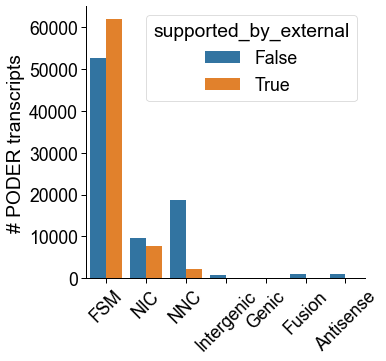

In [52]:
init_plot_settings(aspect='square')
c_dict, order = get_novelty_colors(temp['structural_category'].unique().tolist())
ax = sns.barplot(temp, x='structural_category', hue='supported_by_external', 
            y='n_t', order=order)
ylabel = '# PODER transcripts'
ax.set(ylabel=ylabel, xlabel='')
clean_figure(ax)

In [54]:
temp.to_csv('241031_n_supported_ics_by_novelty.tsv', sep='\t')

## Get GENCODE tid <-> PODER tid correspondences

In [4]:
# get ics again from poder, oops
od = '../../'

gtf_file = proc_cfg(config['lr']['gtf_filt_with_genes'], od)
gtf_df = pr.read_gtf(gtf_file, duplicate_attr=True)

In [5]:
# get ics again from poder, oops
od = '../../'

ref_gtf_file = proc_cfg(config['ref']['gtf'], od)
ref_gtf_df = pr.read_gtf(ref_gtf_file, duplicate_attr=True)

In [6]:
gtf_df = cerberus.get_ic(gtf_df)

In [7]:
ref_gtf_df = cerberus.get_ic(ref_gtf_df)

In [8]:
gtf_df.drop('gene_id', axis=1, inplace=True)

In [9]:
ref_gtf_df.drop('gene_id', axis=1, inplace=True)

In [10]:
tmp = gtf_df.merge(ref_gtf_df,
                      how='left',
                      on=['Chromosome', 'Strand', 'ic'],
                      suffixes=('', '_gencode_v47'))
                      

In [11]:
temp2 = tmp[['transcript_id', 'transcript_id_gencode_v47']].groupby('transcript_id').nunique()

In [12]:
len(temp2)

155875

In [13]:
len(temp2.loc[temp2.transcript_id_gencode_v47>1])

1506

In [15]:
# add associated gene biotype
mt_df = pd.read_csv('../../data/05_mastertable/poder_master_table.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)
mt_df.rename({'isoform': 'transcript_id'}, axis=1, inplace=True)

In [16]:
temp2 = temp2.merge(mt_df[['transcript_id', 'associated_gene_biotype']], how='left', on='transcript_id')

In [17]:
temp2.associated_gene_biotype.unique()

array(['Protein Coding', 'lncRNA', 'Novel/Ambiguous Gene'], dtype=object)

In [18]:
temp2.to_csv('poder_to_gencode_v47_tid.tsv', sep='\t')

In [19]:
temp2.head()

,transcript_id,transcript_id_gencode_v47,associated_gene_biotype
0,ENST00000010132.6,1,Protein Coding
1,ENST00000013894.3,1,Protein Coding
2,ENST00000075120.12,2,Protein Coding
3,ENST00000155093.8,1,Protein Coding
4,ENST00000156084.8,1,Protein Coding
